# Polarized observations

This tutorial covers working with polarized instrument and maps, and recovering polarized maps from observations.

We start with a normal instrument, and create two orthogonally polarized copies of each detector by setting ``polarized: True`` in the ``Array`` config:

In [1]:
import maria
from maria.instrument import Band

f090 = Band(
    center=90e9,  # in Hz
    width=20e9,  # in Hz
    NET_RJ=40e-6,  # in K sqrt(s)
    knee=1e0,    # in Hz
    gain_error=5e-2)

f150 = Band(
    center=150e9, 
    width=30e9, 
    NET_RJ=60e-6, 
    knee=1e0, 
    gain_error=5e-2)

array = {"field_of_view": 0.5, 
         "shape": "circle", 
         "beam_spacing": 1.5,
         "primary_size": 10, 
         "polarized": True,
         "bands": [f090, f150]}

instrument = maria.get_instrument(array=array)

print(instrument.arrays)

          n     FOV baseline        bands polarized
array1  652  0.478°      0 m  [f090,f150]      True


We can see the resulting polarization footprint in the instrument plot:

Instrument(1 array)
├ arrays:
│            n     FOV baseline        bands polarized
│  array1  652  0.478°      0 m  [f090,f150]      True
│ 
└ bands:
      name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
   0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s   1.458’
   1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.8748’


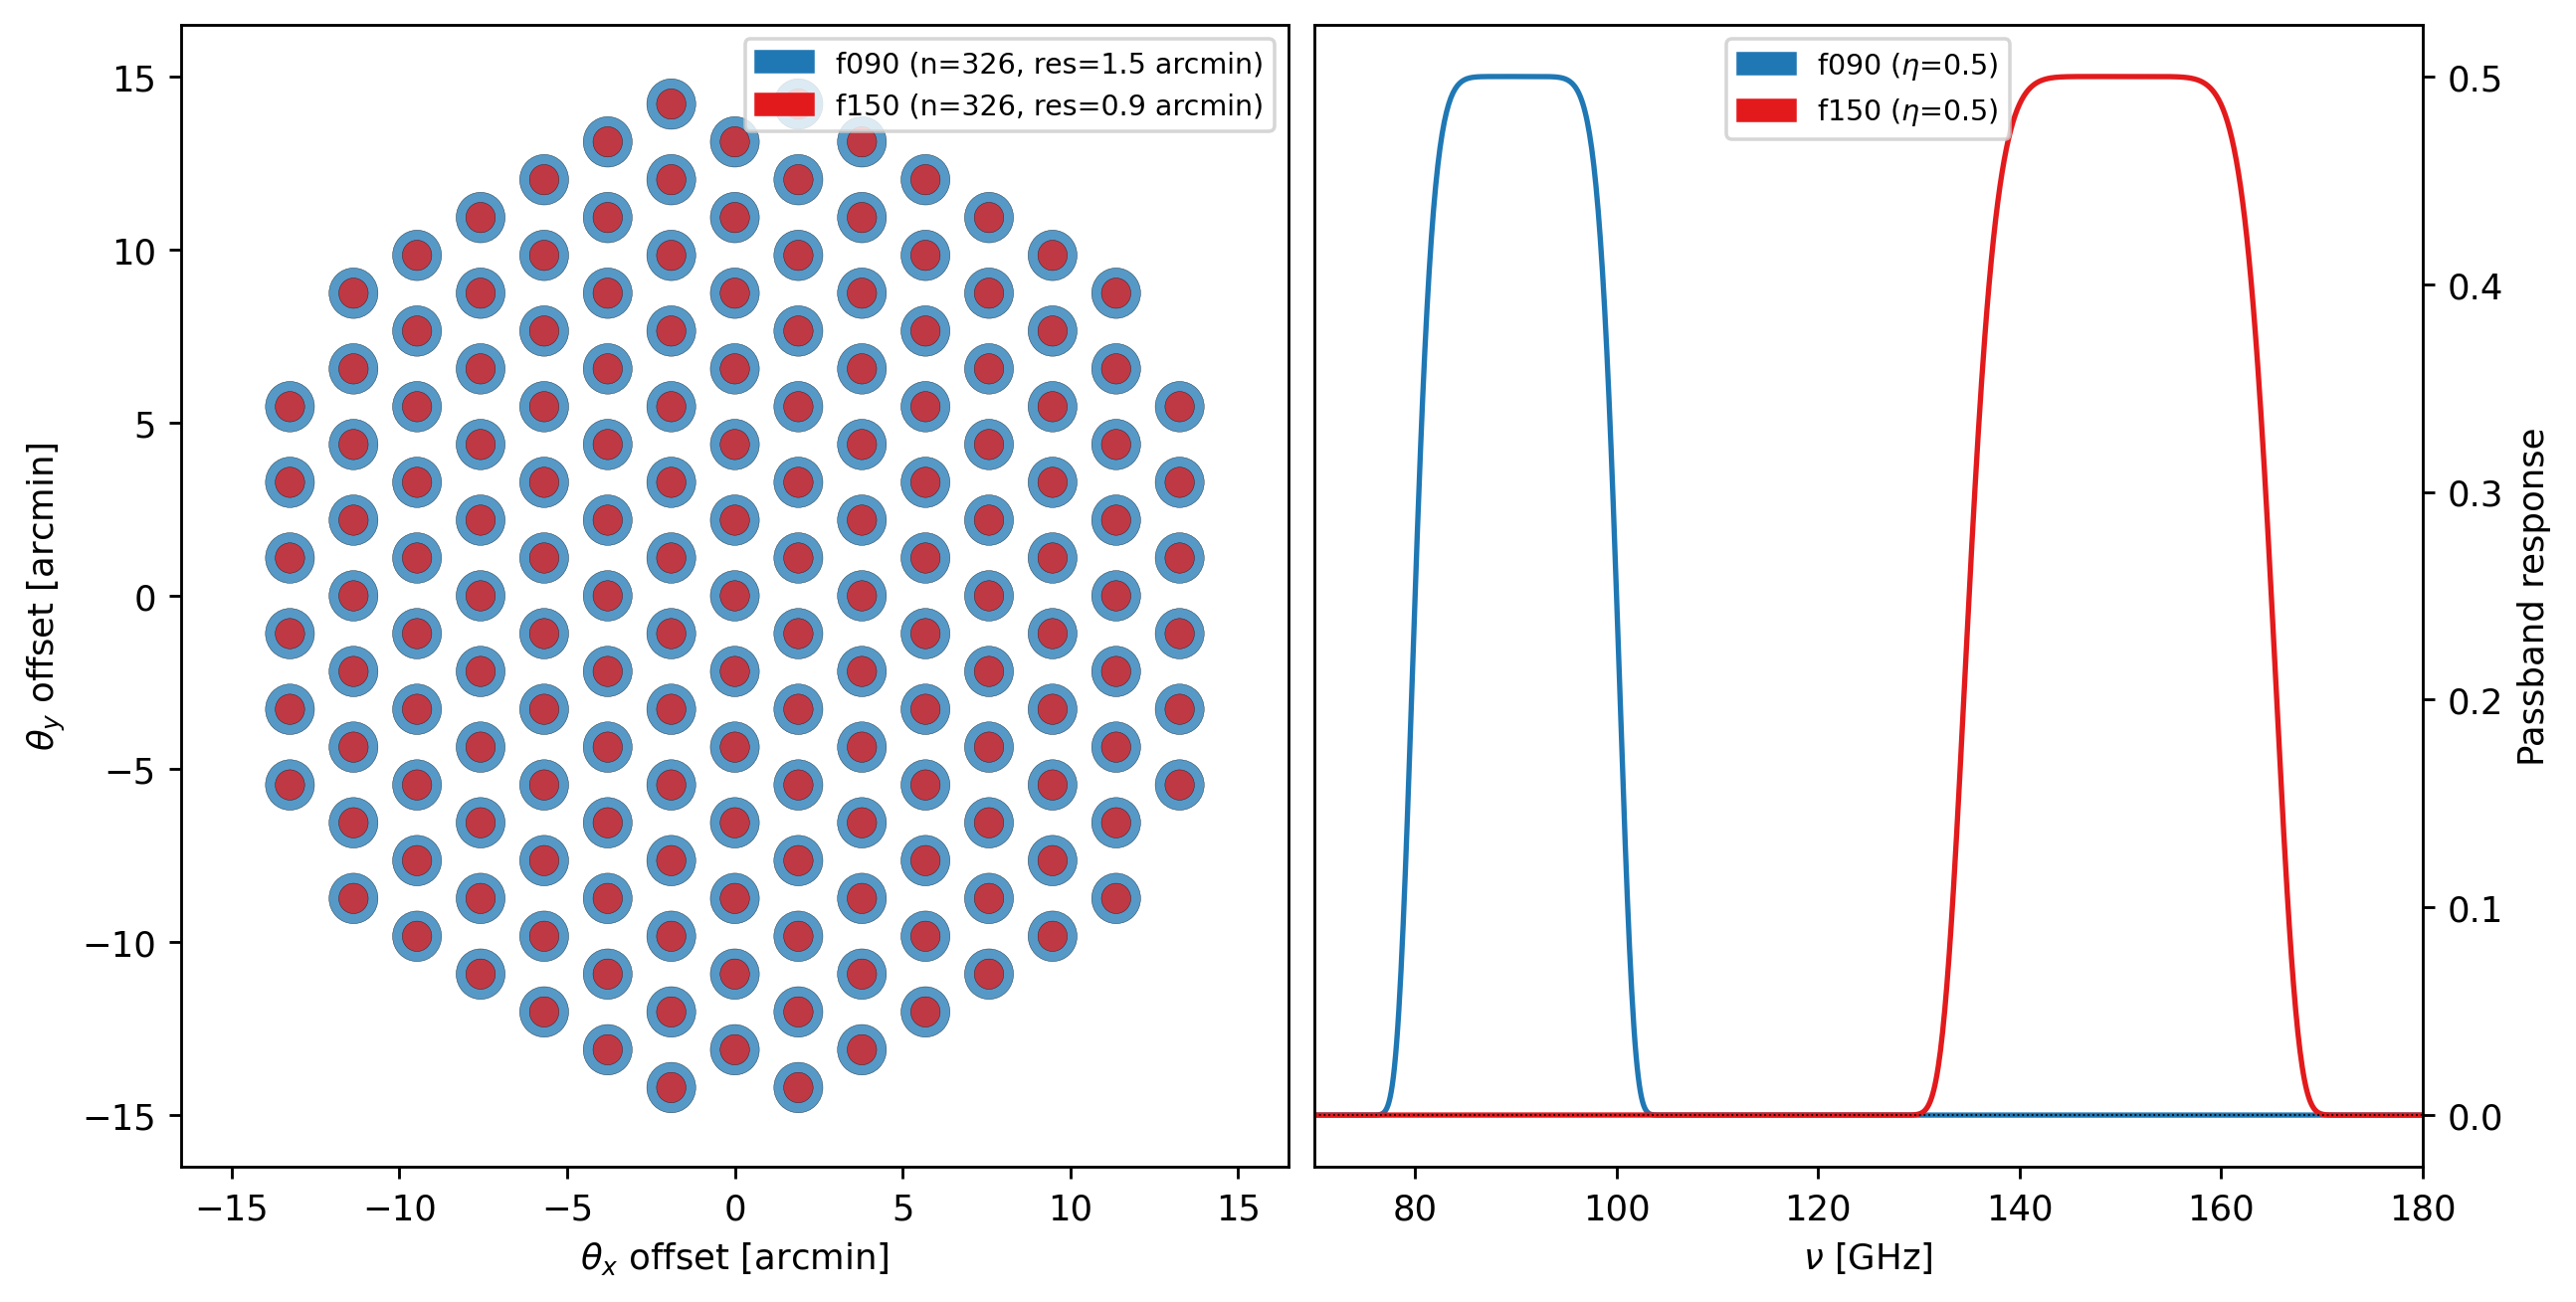

In [2]:
print(instrument)
instrument.plot()

Let's observe the use the Einstein map, which has a faint polarization signature underneath the unpolarized signal of Einstein's face. Remember that all maps are five dimensional (stokes, frequency, time, y, x); this map has four channels in the stokes dimensions (the I, Q, U, and V [Stokes parameters](https://en.wikipedia.org/wiki/Stokes_parameters)). We can plot all the channels by giving ``plot`` a shaped set of stokes parameters.

2025-11-28 07:59:24.376 INFO: Fetching https://github.com/thomaswmorris/maria-data/raw/master/maps/einstein.h5


Downloading:   0%|                | 0.00/931k [00:00<?, ?B/s]

Downloading: 100%|████████████████| 931k/931k [00:00<00:00, 37.2MB/s]

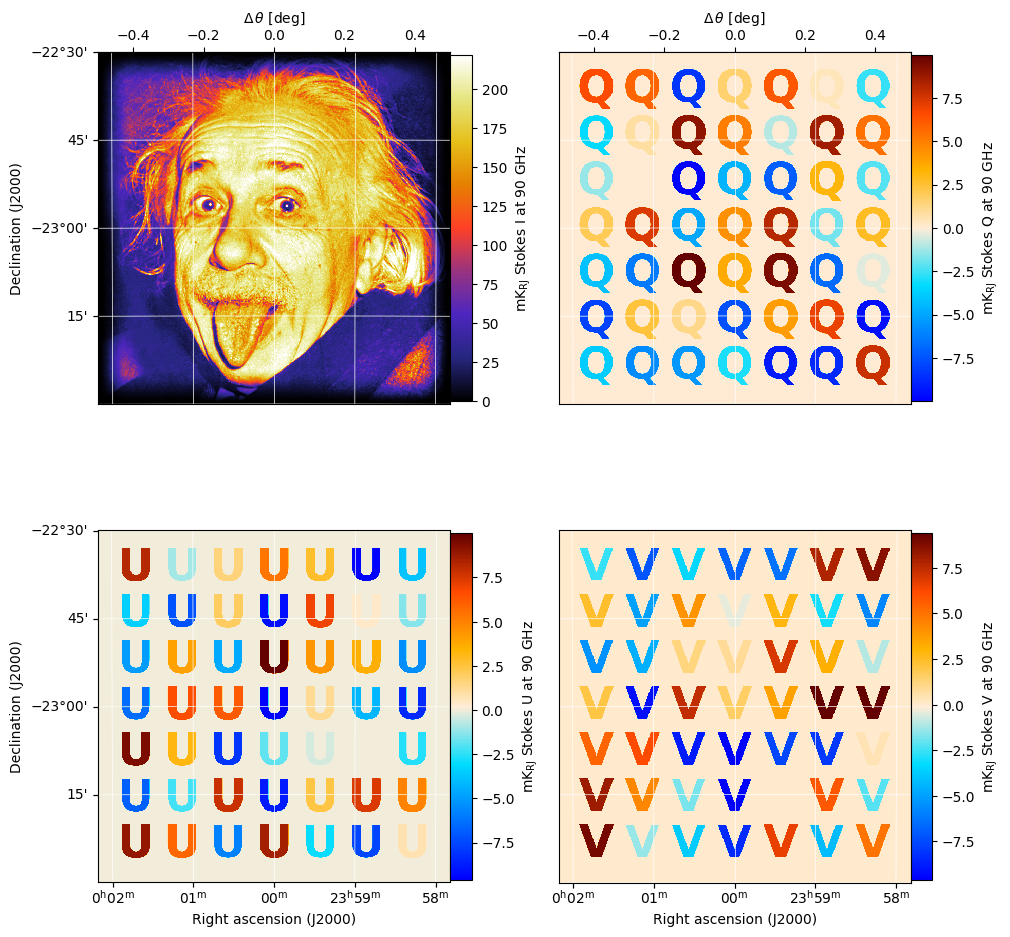

In [3]:
from maria.io import fetch

input_map = maria.map.load(fetch("maps/einstein.h5"))
input_map.plot(stokes=[["I", "Q"], 
                       ["U", "V"]])

PlanList(1 plans, 900 s):
                           start_time duration target(ra,dec)     center(az,el)
chunk                                                                          
0      2025-11-28 21:50:05.524 +00:00    900 s   (360°, -23°)  (95.75°, 61.84°)


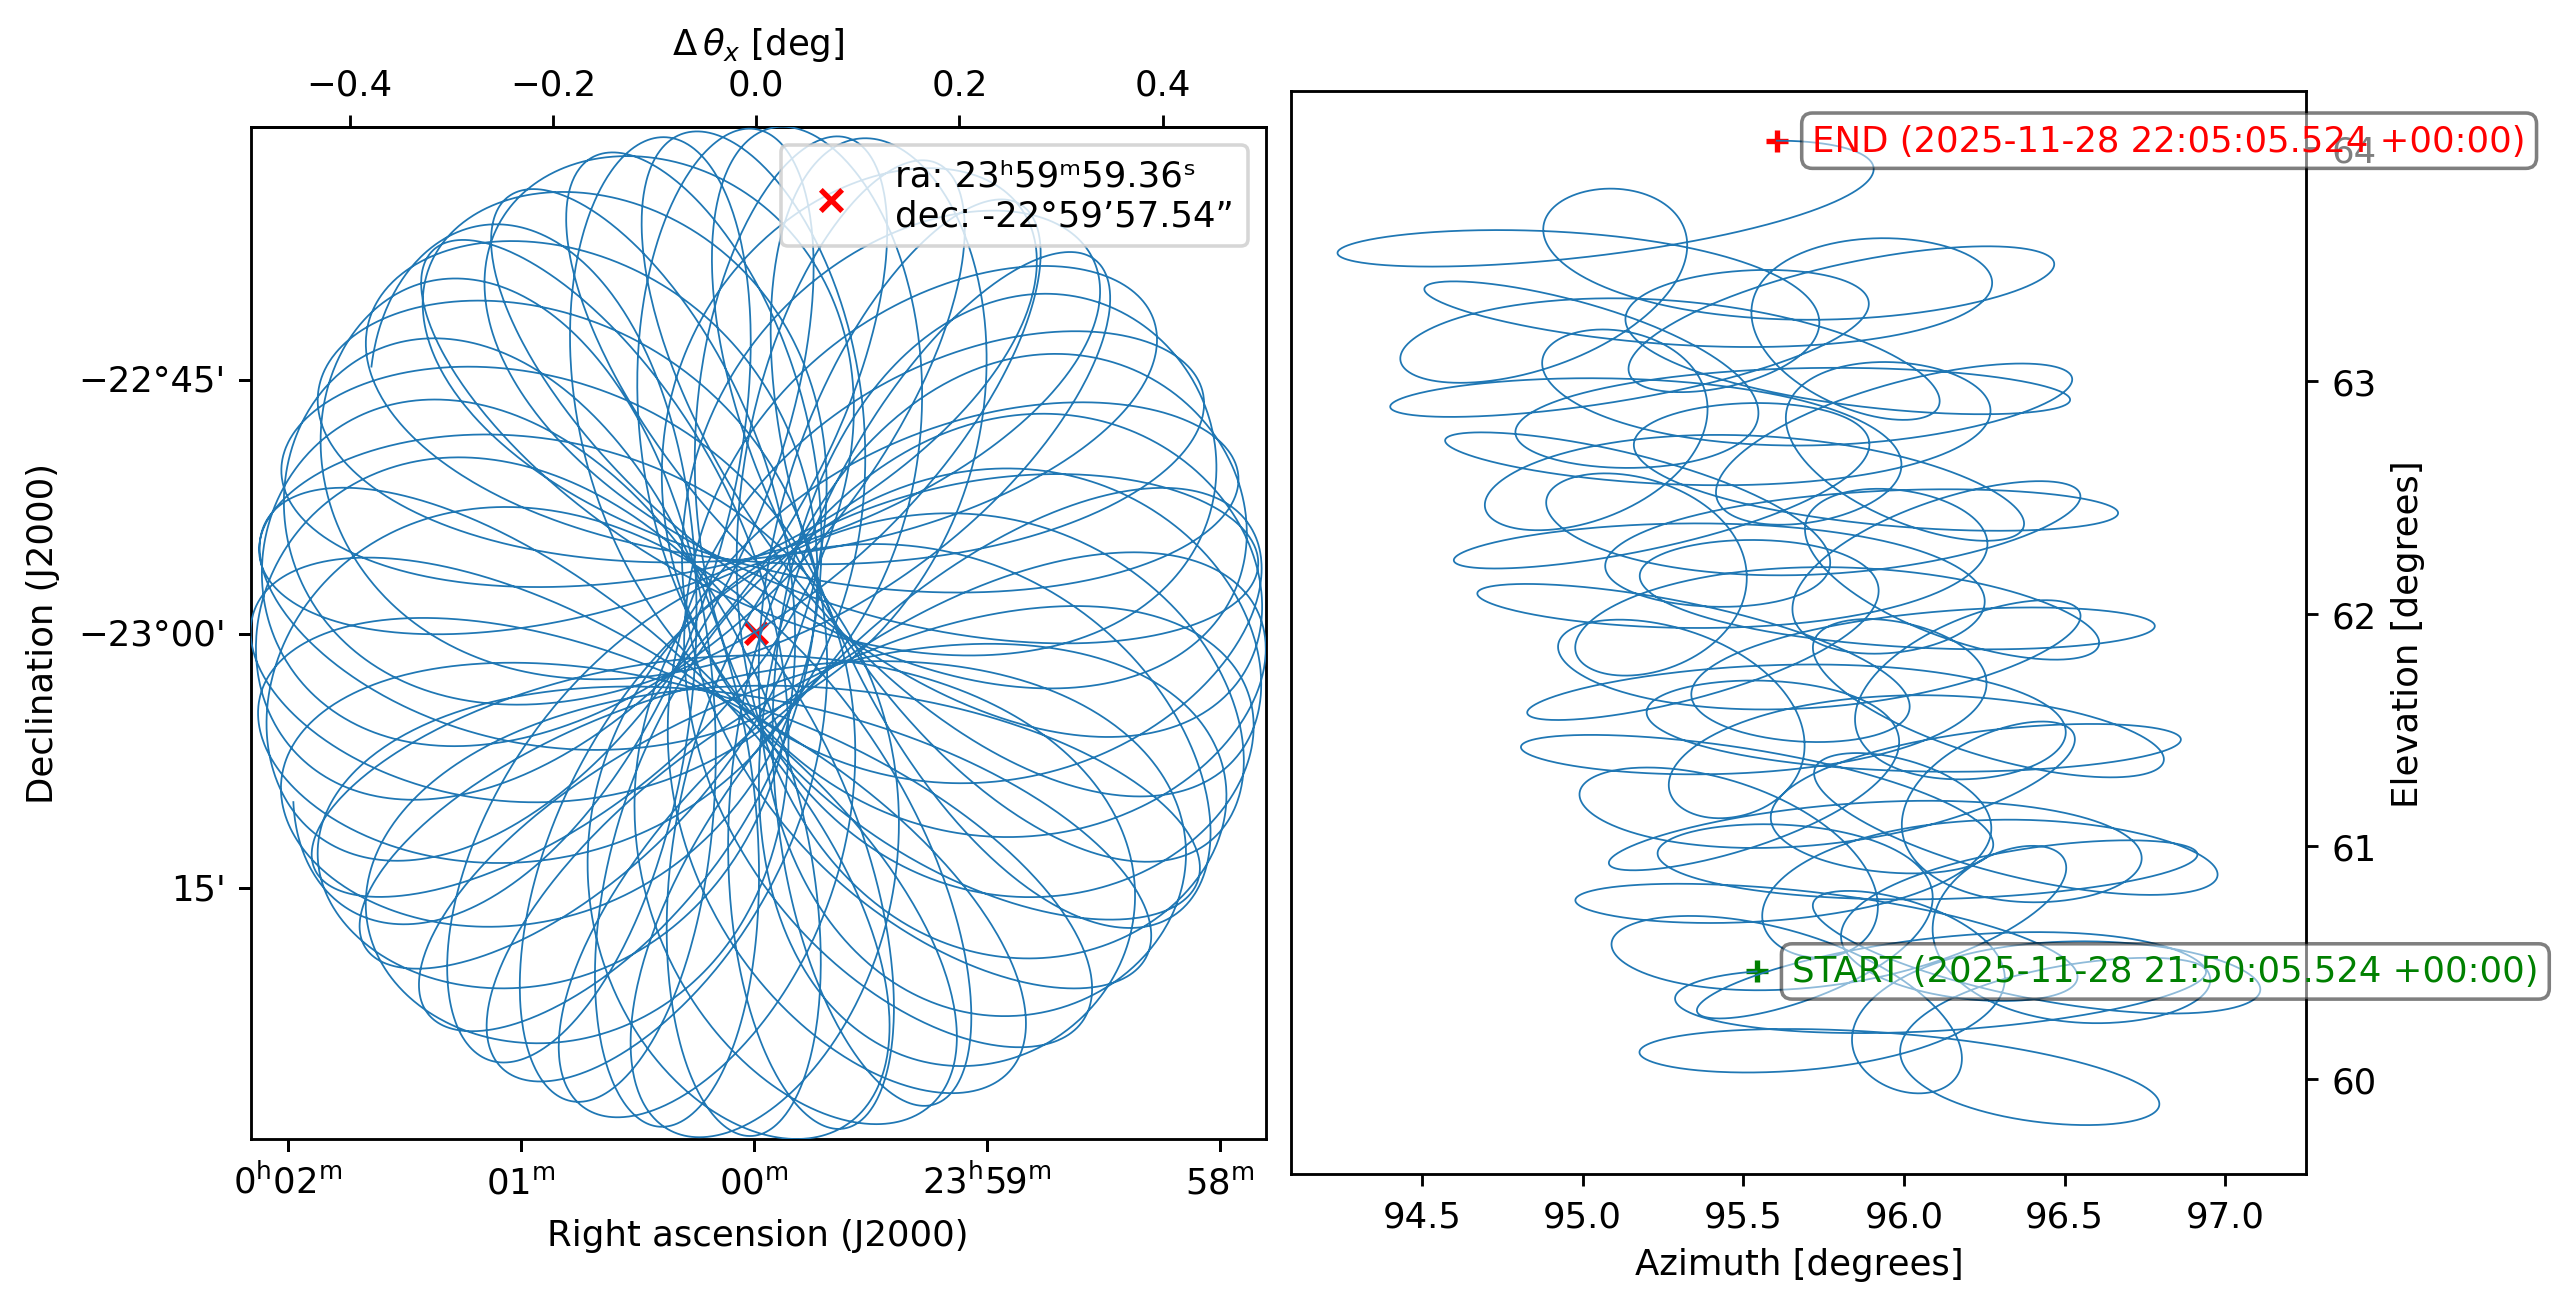

In [4]:
from maria import Planner

planner = Planner(target=input_map, site="llano_de_chajnantor", constraints={"el": (60, 90)})
plans = planner.generate_plans(total_duration=900,  # in seconds
                               sample_rate=50)  # in Hz

plans[0].plot()
print(plans)

In [5]:
sim = maria.Simulation(
    instrument,
    plans=plans,
    site="llano_de_chajnantor",
    atmosphere="2d",
    atmosphere_kwargs={"weather": {"pwv": 0.5}},
    map=input_map
)

print(sim)

Simulation
├ Instrument(1 array)
│ ├ arrays:
│ │            n     FOV baseline        bands polarized
│ │  array1  652  0.478°      0 m  [f090,f150]      True
│ │ 
│ └ bands:
│       name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
│    0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s   1.458’
│    1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.8748’
├ Site:
│   region: chajnantor
│   timezone: America/Santiago
│   location:
│     longitude: 67°45’17.28” W
│     latitude:  23°01’45.84” S
│     altitude: 5064 m
│   seasonal: True
│   diurnal: True
├ PlanList(1 plans, 900 s):
│                            start_time duration target(ra,dec)     center(az,el)
│ chunk                                                                          
│ 0      2025-11-28 21:50:05.524 +00:00    900 s   (360°, -23°)  (95.75°, 61.84°)
├ '2d'
└ ProjectionMap:
    shape(stokes, nu, t, y, x): (4, 1, 1, 685, 685)
    stokes: IQUV
    nu

2025-11-28 07:59:35.539 INFO: Simulating observation 1 of 1


Constructing atmosphere:   0%|                | 0/8 [00:00<?, ?it/s]

Constructing atmosphere:  12%|██              | 1/8 [00:02<00:17,  2.53s/it]

Constructing atmosphere:  25%|████            | 2/8 [00:05<00:16,  2.79s/it]

Constructing atmosphere:  38%|██████          | 3/8 [00:08<00:13,  2.79s/it]

Constructing atmosphere:  50%|████████        | 4/8 [00:11<00:11,  2.98s/it]

Constructing atmosphere:  62%|██████████      | 5/8 [00:14<00:08,  2.80s/it]

Constructing atmosphere:  75%|████████████    | 6/8 [00:16<00:05,  2.73s/it]

Constructing atmosphere:  88%|██████████████  | 7/8 [00:19<00:02,  2.64s/it]

Constructing atmosphere: 100%|████████████████| 8/8 [00:21<00:00,  2.58s/it]

Constructing atmosphere: 100%|████████████████| 8/8 [00:21<00:00,  2.69s/it]

Generating turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Generating turbulence:  25%|████            | 2/8 [00:00<00:00, 12.92it/s]

Generating turbulence:  50%|████████        | 4/8 [00:00<00:00, 11.04it/s]

Generating turbulence:  75%|████████████    | 6/8 [00:00<00:00,  7.45it/s]

Generating turbulence:  88%|██████████████  | 7/8 [00:01<00:00,  4.51it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:01<00:00,  3.28it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:01<00:00,  4.55it/s]

Sampling turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Sampling turbulence:  12%|██              | 1/8 [00:01<00:11,  1.64s/it]

Sampling turbulence:  25%|████            | 2/8 [00:02<00:07,  1.17s/it]

Sampling turbulence:  38%|██████          | 3/8 [00:03<00:05,  1.04s/it]

Sampling turbulence:  50%|████████        | 4/8 [00:04<00:03,  1.02it/s]

Sampling turbulence:  62%|██████████      | 5/8 [00:05<00:02,  1.05it/s]

Sampling turbulence:  75%|████████████    | 6/8 [00:06<00:01,  1.06it/s]

Sampling turbulence:  88%|██████████████  | 7/8 [00:07<00:00,  1.06it/s]

Sampling turbulence: 100%|████████████████| 8/8 [00:08<00:00,  1.05it/s]

Sampling turbulence: 100%|████████████████| 8/8 [00:08<00:00,  1.00s/it]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.90s/it, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.90s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.06s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.18s/it, band=f150]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=, channel=, stokes=]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]               

Sampling map:   0%|                | 0/2 [00:04<?, ?it/s, band=f090, channel=(0 Hz, inf Hz)]

Sampling map:  50%|████████        | 1/2 [00:08<00:08,  8.42s/it, band=f090, channel=(0 Hz, inf Hz)]

Sampling map:  50%|████████        | 1/2 [00:08<00:08,  8.42s/it, band=f150]                        

Sampling map:  50%|████████        | 1/2 [00:11<00:08,  8.42s/it, band=f150, channel=(0 Hz, inf Hz)]

Sampling map: 100%|████████████████| 2/2 [00:15<00:00,  7.78s/it, band=f150, channel=(0 Hz, inf Hz)]

Sampling map: 100%|████████████████| 2/2 [00:15<00:00,  7.88s/it, band=f150, channel=(0 Hz, inf Hz)]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  1.22it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  1.22it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:01<00:00,  1.58it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:01<00:00,  1.51it/s, band=f150]

2025-11-28 08:00:47.153 INFO: Simulated observation 1 of 1 in 71.6 s


[TOD(shape=(652, 45000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-11-28 22:05:05.504 +00:00, duration=900.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-11-28T08:00:29.053802+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 278.728})]


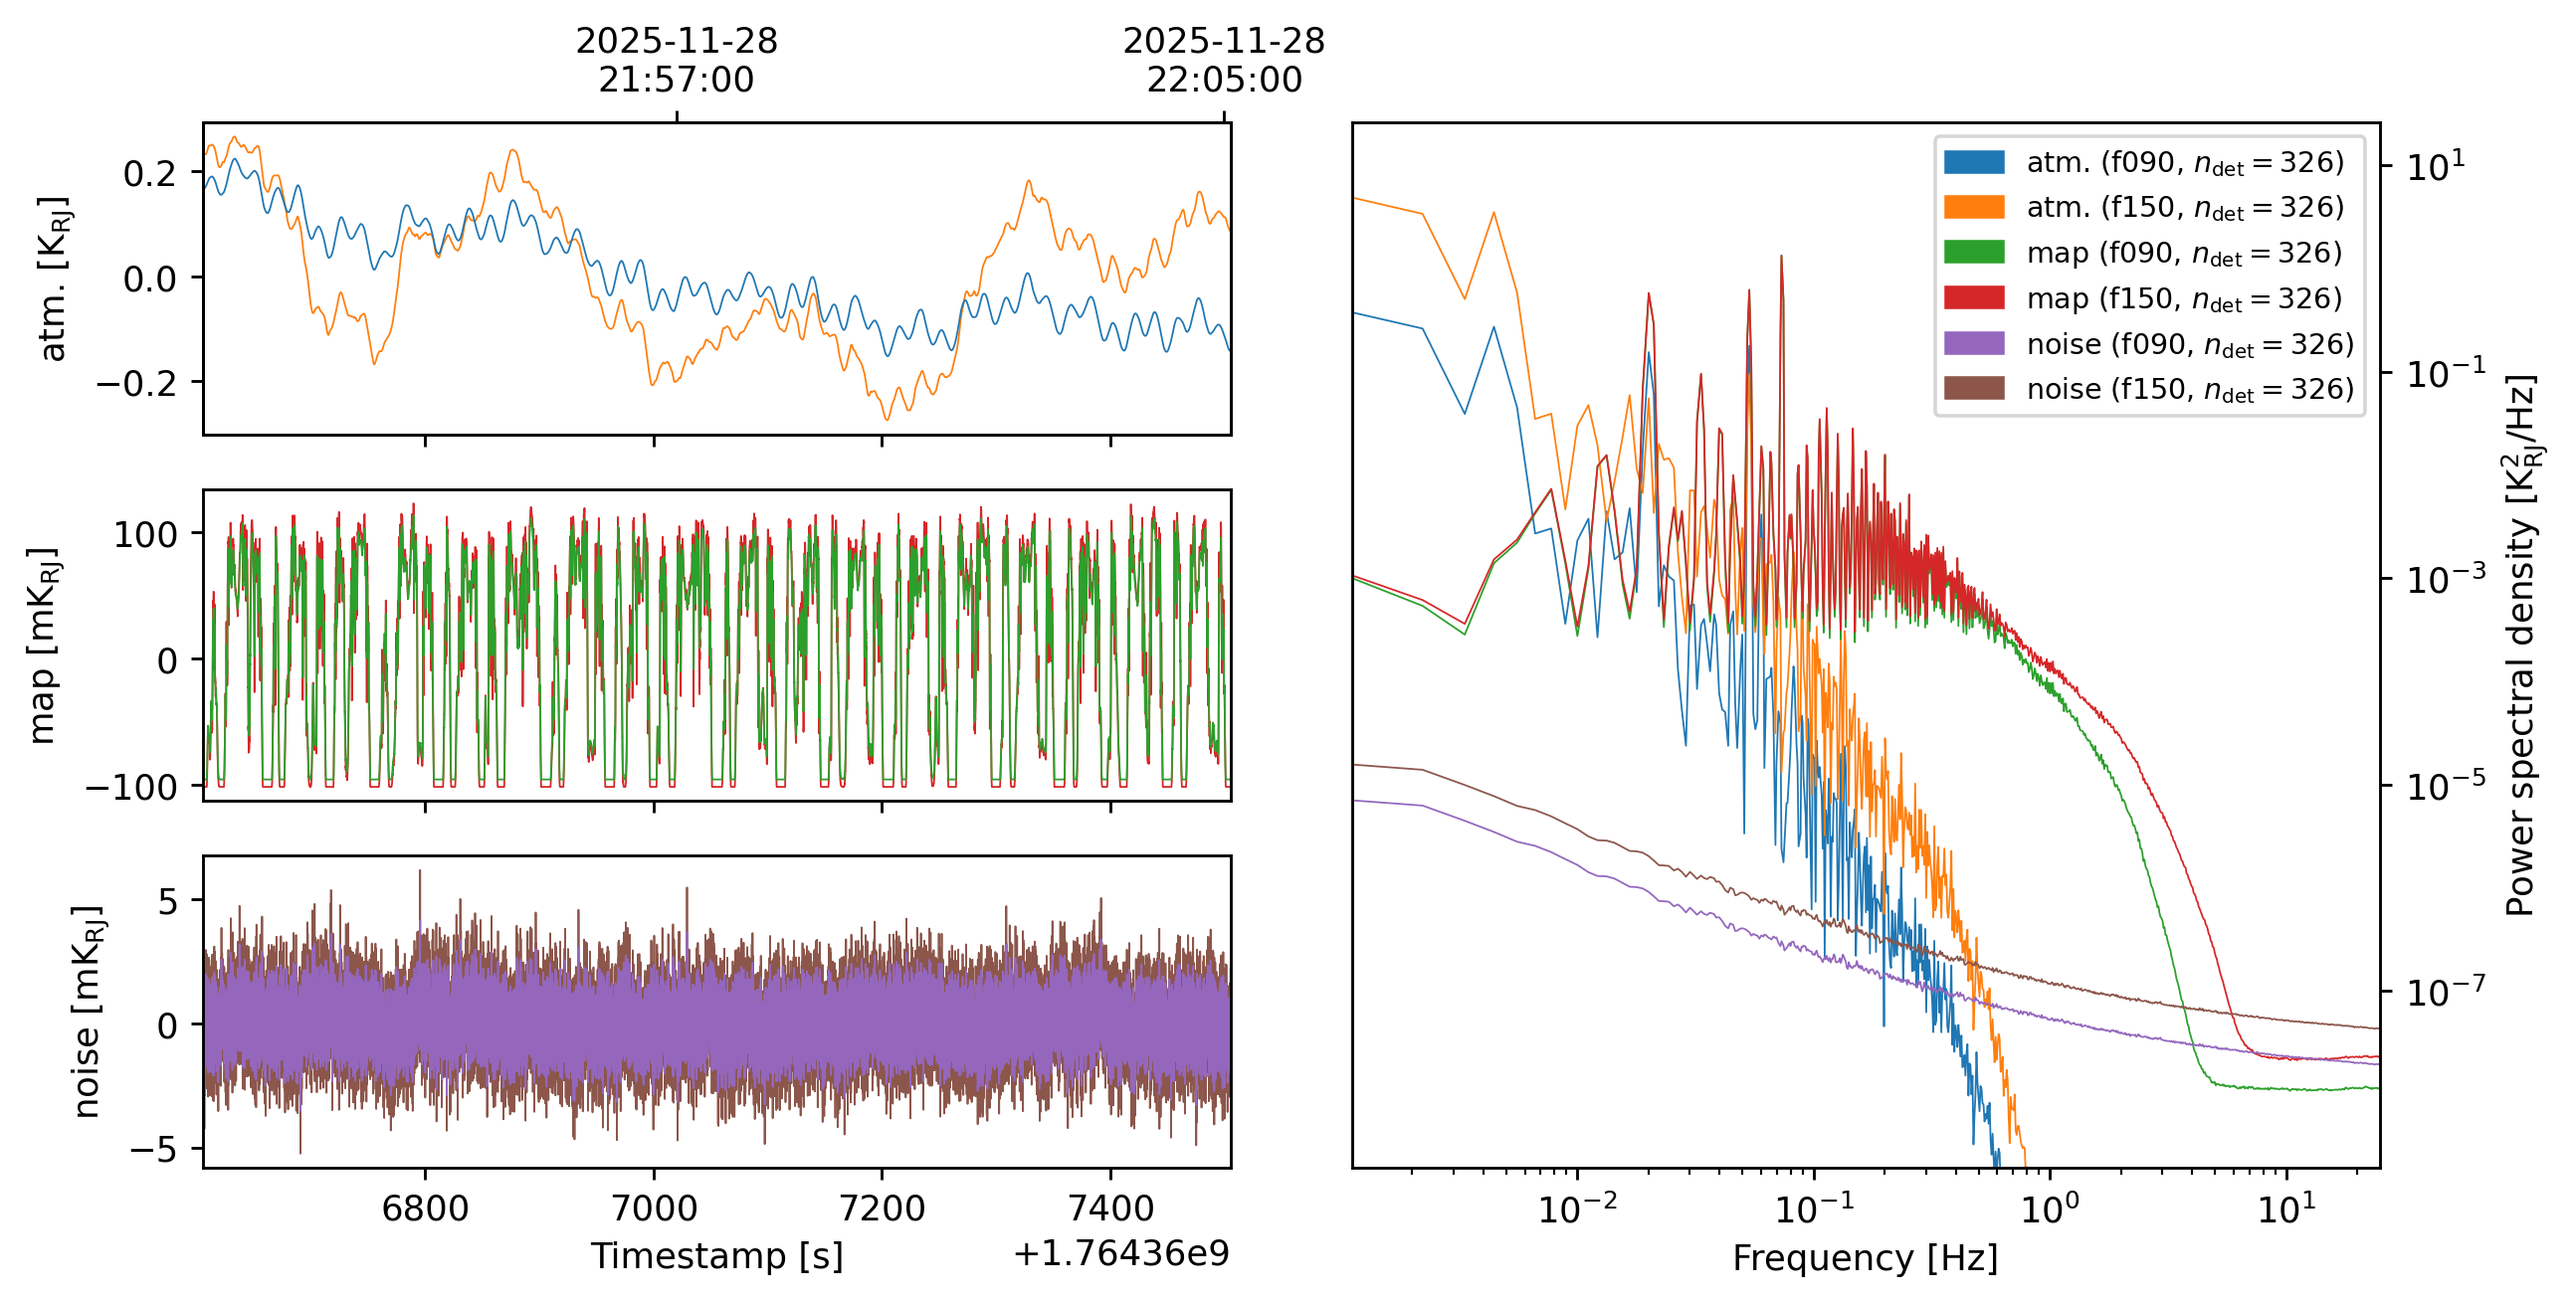

In [6]:
tods = sim.run()

print(tods)
tods[0].plot()

In [7]:
from maria.mappers import BinMapper

mapper = BinMapper(
    stokes="IQUV",
    frame="ra/dec",
    resolution=0.25 / 60,
    tod_preprocessing={
        "remove_spline": {"knot_spacing": 60, "remove_el_gradient": True},
        "remove_modes": {"modes_to_remove": 1},
    },
    map_postprocessing={
        "gaussian_filter": {"sigma": 1},
    },
    units="mK_RJ",
    tods=tods,
)

output_map = mapper.run()

print(output_map)

2025-11-28 08:00:58.219 INFO: Inferring center {'ra': '23ʰ59ᵐ59.37ˢ', 'dec': '-22°59’57.54”'} for mapper.


2025-11-28 08:00:58.234 INFO: Inferring mapper width 1.466° for mapper from observation patch.


2025-11-28 08:00:58.235 INFO: Inferring mapper height 1.466° to match supplied width.


Preprocessing TODs:   0%|                | 0/1 [00:00<?, ?it/s]

Preprocessing TODs: 100%|████████████████| 1/1 [00:02<00:00,  2.21s/it]

Preprocessing TODs: 100%|████████████████| 1/1 [00:02<00:00,  2.21s/it]

Mapping:   0%|          | 0/1 [00:00<?, ?it/s, tod=1/1]

Mapping: 100%|██████████| 1/1 [00:06<00:00,  6.74s/it, tod=1/1]

Mapping: 100%|██████████| 1/1 [00:06<00:00,  6.74s/it, tod=1/1]


2025-11-28 08:01:07.451 WARNING: No counts for map (stokes=V, nu=90 GHz)


2025-11-28 08:01:07.460 WARNING: No counts for map (stokes=V, nu=150 GHz)


ProjectionMap:
  shape(stokes, nu, t, y, x): (4, 2, 1, 351, 351)
  stokes: IQUV
  nu: [ 90. 150.] GHz
  t: [1.76436706e+09]
  z: naive
  quantity: rayleigh_jeans_temperature
  units: mK_RJ
    min: -1.143e+02
    max: 1.428e+02
    rms: nan
  center:
    ra: 23ʰ59ᵐ59.37ˢ
    dec: -22°59’57.54”
  size(y, x): (1.462°, 1.462°)
  resolution(y, x): (15”, 15”)
  beam(maj, min, rot): [[[[1.45801568 1.45801568 0.        ]]

  [[0.87480941 0.87480941 0.        ]]]


 [[[1.45801568 1.45801568 0.        ]]

  [[0.87480941 0.87480941 0.        ]]]


 [[[1.45801568 1.45801568 0.        ]]

  [[0.87480941 0.87480941 0.        ]]]


 [[[1.45801568 1.45801568 0.        ]]

  [[0.87480941 0.87480941 0.        ]]]]’
  memory: 15.77 MB


Note that we can't see any of the circular polarization, since our instrument isn't sensitive to it.

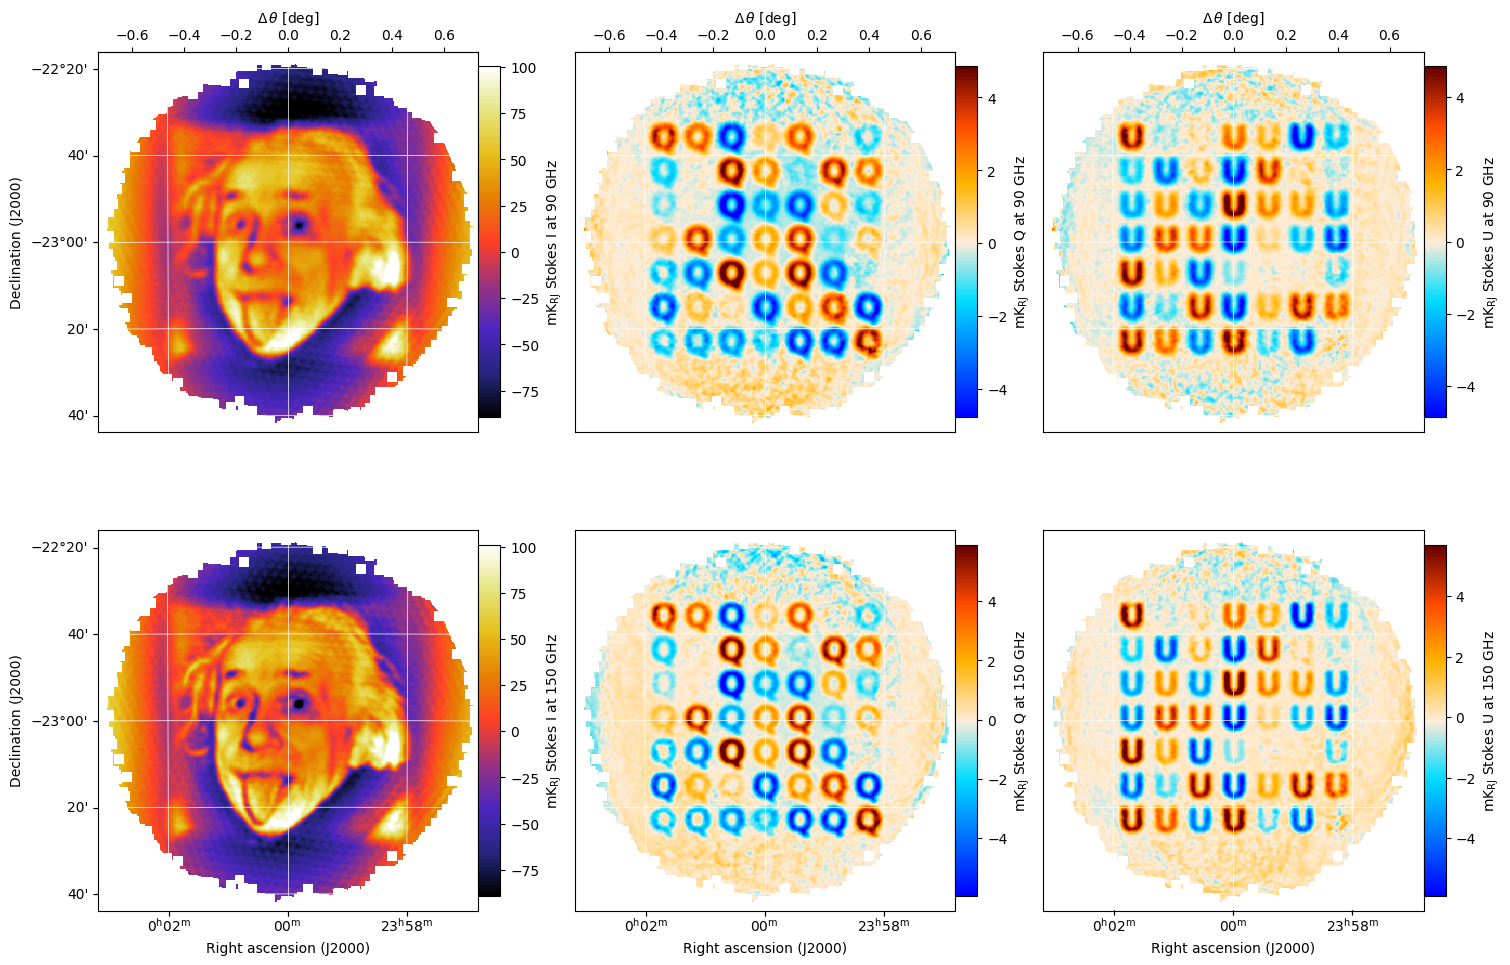

In [8]:
output_map.plot(stokes=["I", "Q", "U"], nu_index=[[0], [1]])